# DAM Mutagensis Analysis

Experiment: I was given two samples, 1 that had a working dam methylase and 1 that had a non-working dam methylase. I barcoded the samples, barcode 6 is active dam methylase and barcode 16 is inactive dam methylase. 

1. Modification Basecalling via Dorado
2. Align the modified basecalled data to the reference genome provided via Minimap2
3. Split the aligned data via barcode via Dorado demux 
    
    a. Yes there are other barcodes called even though they do not exist, do not be alarmed. This is normal, just ignore them. 
    
4. Use Modikit to see the methylation statistics for each GATC in the dam gene 

# Software Needed 
1. Download miniconda 
    
    a. https://docs.anaconda.com/miniconda/

2. Create a conda environment
    
    a. `conda create -n ont_analysis -y`

3. Activate conda environment
    
    a. `conda activate ont_analysis`

4. Install conda/bioconda packages 
    
    a. `conda install bioconda::samtools bioconda::minimap2 -y` 
    
    b. Learn more about Samtools https://www.htslib.org/

    c. Learn more about Mimimap2 https://github.com/lh3/minimap2

5. Download dorado and modkit 
    
    a. Go to the dorado github page https://github.com/nanoporetech/dorado

    b. Follow the Installation Instructions at the beginning of the github page 

    c. Go to the Modkit github page https://github.com/nanoporetech/modkit
    
    d. Follow the Installation Instructions at the beginning of the github page


# *REPLACE* File Paths with your own 

 - `pwd`

 will give you where you are in your terminal 

In [ ]:
pod5 = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/data/'
basecalled_bam = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/240919_dam_mutagensis_sup_m6a_barcode.bam'

!/home/jem16/dorado-0.7.2-linux-x64/bin/dorado basecaller -x "cuda:all" -r --modified-bases-threshold 0 --trim none sup,6mA --kit-name SQK-NBD114-24 {pod5} > {basecalled_bam}

In [ ]:
# Convert bam file to fastq file because Minimap2 needs a fastq file
# need to include BC to know which barcode this is to validate the dam mutation difference based on methylation
# include the MM and ML tags for modification score and which base associated to each modification score 
basecalled_fastq_gz = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/240919_dam_mutagensis_sup_m6a_barcode.fastq.gz'
threads = 12

!samtools fastq -@ {threads} -T MM,ML,BC {basecalled_bam} | gzip > {basecalled_fastq_gz}


In [ ]:
reference = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/seqdisp_dam_v2_reloc_ecori.fasta'
output = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/'
basecalled_aligned_bam = '240919_dam_mutagensis_sup_m6a_barcode_aligned.bam'

!minimap2 -ax map-ont -t {threads} --MD -y --secondary=no {reference} {basecalled_fastq_gz} | samtools view -@{threads} -Sb -F256 -F2048 -q5| samtools sort -@{threads} -T {output} > {basecalled_aligned_bam}

In [ ]:
!/home/jem16/dorado-0.7.2-linux-x64/bin/dorado demux --kit-name SQK-NBD114-24 -o {output} -t {threads} -v --no-trim --sort-bam {basecalled_aligned_bam}

The below will aggregate all the GATC sites aligned to the region we are looking for and give a probability of each A methylated at each GATC position in the region subsetted for. Do this for *BOTH* barcoded bam files  

In [ ]:
dam_gene = "SeqDisp_DAM_V2_reloc_EcoRI:651-1489"
inactive_dam_bam = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/240919_dam_mutagensis_sup_m6a_barcode_6_aligned_dam_gene.bam'
inactive_dam_pileup_bed = '240919_dam_mutagensis_sup_m6a_barcode_6_aligned_dam_gene_modkit_pileup.bed'

!/home/jem16/modkit_v0.3.0/dist/modkit pileup --motif GATC 1 -r {reference} --no-filtering -t {threads} --combine-strands --region {dam_gene} {inactive_dam_bam} {inactive_dam_pileup_bed}

# Further Analysis

If you would like to do what I did also install pandas, matplotlib and numpy like you did for samtools and minimap2

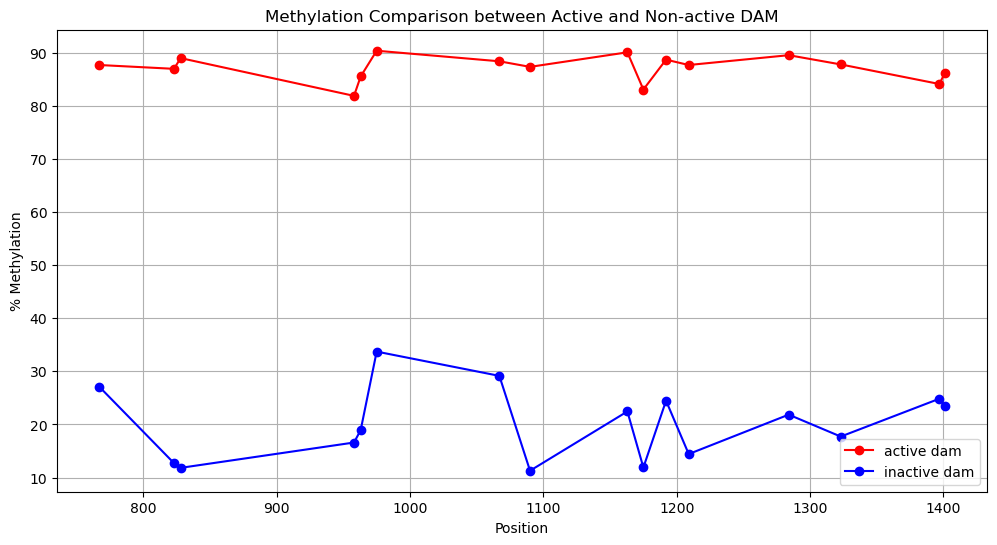

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the first BED file
bed_file_1 = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/240919_dam_mutagensis_sup_m6a_barcode_6_aligned_dam_gene_modkit_pileup_combine.bed'
data1 = pd.read_csv(bed_file_1, sep='\t', header=None, usecols=[1, 10], names=['Position', 'Methylation'])

# Read the second BED file
bed_file_2 = '/pym/Data/Nanopore/projects/dam_mutagensis_collab/240919_dam_mutagensis_sup_m6a_barcode_16_aligned_dam_gene_modkit_pileup_combine.bed'
data2 = pd.read_csv(bed_file_2, sep='\t', header=None, usecols=[1, 10], names=['Position', 'Methylation'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot the first dataset
plt.plot(data1['Position'], data1['Methylation'], label='active dam', color='red', linestyle='-', marker='o')

# Plot the second dataset
plt.plot(data2['Position'], data2['Methylation'], label='inactive dam', color='blue', linestyle='-', marker='o')

# Adding labels and title
plt.xlabel('Position')
plt.ylabel('% Methylation')
plt.title('Methylation Comparison between Active and Non-active DAM')
plt.legend()
plt.grid()

# Show the plot
plt.show()



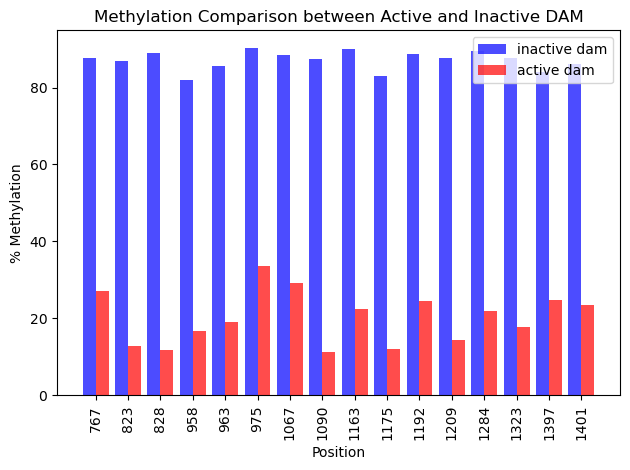

In [23]:
import numpy as np 

bar_width = 0.4
positions1 = np.arange(len(data1))
positions2 = positions1 + bar_width

# Create bars for the first dataset
plt.bar(positions1, data1['Methylation'], width=bar_width, label='inactive dam', color='blue', alpha=0.7)

# Create bars for the second dataset
plt.bar(positions2, data2['Methylation'], width=bar_width, label='active dam', color='red', alpha=0.7)

# Adding labels and title
plt.xlabel('Position')
plt.ylabel('% Methylation')
plt.title('Methylation Comparison between Active and Inactive DAM')
plt.xticks(positions1 + bar_width / 2, data1['Position'], rotation=90)  # Set x-ticks to positions
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()

